In [230]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from scipy.stats import gaussian_kde


In [232]:
def compute_feature_kde(data_feature, grid_points=100):
    """
    Compute the KDE estimate for one feature.
    Returns: grid (1D array) and density values (1D array)
    """
    kde = gaussian_kde(data_feature)
    grid = np.linspace(np.min(data_feature), np.max(data_feature), grid_points)
    density = kde(grid)
    return grid, density


In [233]:
def count_turning_points(grid, density):
    """
    Count turning points in the density estimate.
    A turning point is detected when the sign of the gradient changes.
    (This is a simple implementation.)
    """
    grad = np.gradient(density, grid)
    tp = 0
    for i in range(1, len(grad)):
        if grad[i-1] * grad[i] < 0:
            tp += 1
    return tp


In [236]:
def determine_candidate_k(data, min_k=2):
    """
    For each feature, compute the KDE and count turning points.
    Then set candidate k values in the range [k_min, k_min + k_range],
    where k_min is the minimum turning point count (or at least 2)
    and k_range is the maximum turning point count across features.
    """
    n_features = data.shape[1]
    tp_counts = []
    for j in range(n_features):
        grid, density = compute_feature_kde(data[:, j])
        tp = count_turning_points(grid, density)
        tp_counts.append(tp)
    k_min = max(min_k, int(np.min(tp_counts)))
    k_range = int(np.max(tp_counts))
    candidate_ks = list(range(k_min, k_min + k_range + 1))
    return candidate_ks

In [237]:
def initial_centroids_from_quantiles(data, k):
    """
    For each feature, split the distribution into k equal–probability segments,
    then take the midpoint of each segment as the candidate coordinate.
    The overall centroid for cluster i is formed by taking the midpoint from each feature.
    """
    n_features = data.shape[1]
    centroids = np.zeros((k, n_features))
    for j in range(n_features): # each feature
        sorted_vals = np.sort(data[:, j])
        for i in range(k): # each segment
            q_low = np.quantile(sorted_vals, i/k)
            q_high = np.quantile(sorted_vals, (i+1)/k)
            centroids[i, j] = (q_low + q_high) / 2.0
    return centroids

In [238]:
def initialize_kmeans(init_data, random_state=42):
    """
    Determines the initial number of clusters and centroids using the initial data.
    Tries candidate k's based on turning points and selects the one with the best silhouette score.
    Returns a state dictionary containing:
      - "k": chosen number of clusters
      - "centroids": current centroids (numpy array)
      - "cluster_counts": a count per cluster (for online updates)
    """
    candidate_ks = determine_candidate_k(init_data)
    best_score = -1
    best_centroids = None
    best_k = None
    
    for k in candidate_ks:
        init_centroids = initial_centroids_from_quantiles(init_data, k)
        kmeans = KMeans(n_clusters=k, init=init_centroids, n_init=1, random_state=random_state)
        labels = kmeans.fit_predict(init_data)
        if len(np.unique(labels)) > 1:
            score = silhouette_score(init_data, labels)
        else:
            score = -1
        if score > best_score:
            best_score = score
            best_centroids = kmeans.cluster_centers_
            best_k = k

    state = {
        "k": best_k,
        "centroids": best_centroids,
        "cluster_counts": np.zeros(best_k, dtype=int)
    }
    print(f"Initialized with k={best_k} and silhouette score={best_score:.3f}")
    return state

In [239]:
def assign_cluster(point, centroids):
    """
    Assign a point to the nearest centroid.
    """
    distances = np.linalg.norm(centroids - point, axis=1)
    return np.argmin(distances)

In [240]:
def update_centroid(point, centroids, cluster_counts, cluster_idx):
    """
    Update the centroid for a given cluster using an incremental mean update.
    """
    count = cluster_counts[cluster_idx] # number of element that is assigned to a specific cluster of index idx
    new_count = count + 1
    centroids[cluster_idx] += (point - centroids[cluster_idx]) / new_count
    cluster_counts[cluster_idx] = new_count
    

In [241]:
def process_batch(batch_data, state):
    """
    Process a batch of data points: assign each point to a cluster and update centroids.
    """
    centroids = state["centroids"] # store the best clusters array currently
    cluster_counts = state["cluster_counts"] # how many cluster are there currently
    for point in batch_data:
        cluster_idx = assign_cluster(point, centroids) # return the cluster's index to be assigned to
        update_centroid(point, centroids, cluster_counts, cluster_idx)
    return state

In [242]:
def detect_drift(recent_data, state, random_state=42):
    """
    Simple drift detector: recompute candidate centroids on recent_data and compare the silhouette score.
    Returns the new silhouette score and centroids.
    """
    candidate_ks = determine_candidate_k(recent_data)
    best_score = -1
    best_centroids = None
    k = state["k"]
    if k in candidate_ks:
        init_centroids = initial_centroids_from_quantiles(recent_data, k)
        kmeans = KMeans(n_clusters=k, init=init_centroids, n_init=1, random_state=random_state)
        labels = kmeans.fit_predict(recent_data)
        if len(np.unique(labels)) > 1:
            best_score = silhouette_score(recent_data, labels)
        best_centroids = kmeans.cluster_centers_
    else:
        best_score = -1
    return best_score, best_centroids

In [248]:
def streaming(stream_generator, state, total_points, drift_check_interval=200, min_update_points=50):
    """
    Process the streaming data in batches. Updates the state with online centroid
    updates and checks for drift every 'drift_check_interval' points.
    total points: number of points you want to stream
    drift_check_interval: he number of points after which the algorithm will check drift 
    min_update_points: minimum no of points that need to be in the recent window to perform drift detection
    """
    processed = 0
    recent_window = [] # gets the data from batches
    drift_counter = 0 # A counter that increments with the number of points processed since the last drift check. 
    
    while processed < total_points:
        try:
            batch_data = next(stream_generator)
        except StopIteration:
            print(f"Stream generator exhausted after processing {processed} points.")
            break

        state = process_batch(batch_data, state)
        processed += len(batch_data)
        recent_window.extend(batch_data)
        drift_counter += len(batch_data)
        
        # Check for drift periodically
        if drift_counter >= drift_check_interval and len(recent_window) >= min_update_points:
            recent_array = np.array(recent_window)
            new_score, new_centroids = detect_drift(recent_array, state)
            current_labels = np.array([assign_cluster(x, state["centroids"]) for x in recent_array])
            if len(np.unique(current_labels)) > 1:
                current_score = silhouette_score(recent_array, current_labels)
            else:
                current_score = -1
            if new_score > current_score + 0.05:  # if improvement > 5%
                print(f"Drift detected at point {processed}: Updating centroids (silhouette {current_score:.3f} -> {new_score:.3f})")
                state["centroids"] = new_centroids
                state["cluster_counts"] = np.zeros(state["k"], dtype=int)
            recent_window = []
            drift_counter = 0
                
    print("Streaming completed.")
    return state

In [249]:
def detect_outliers(data, centroids, labels, threshold=2.5):
    """
    Detect outliers in the data based on the distance of each point to its assigned cluster centroid.
    For each cluster, compute the mean and standard deviation of the distances and flag points that
    are more than (mean + threshold * std) away from the centroid as outliers.
    
    Returns:
      outlier_mask: A boolean array with True for points that are considered outliers.
    """
    outlier_mask = np.zeros(len(data), dtype=bool)
    unique_labels = np.unique(labels)
    for cl in unique_labels:
        cluster_indices = np.where(labels == cl)[0]
        cluster_points = data[cluster_indices]
        # Compute Euclidean distances from each point in the cluster to the cluster's centroid.
        distances = np.linalg.norm(cluster_points - centroids[cl], axis=1)
        mean_d = np.mean(distances)
        std_d = np.std(distances)
        # Points that are farther than (mean + threshold * std) are flagged as outliers.
        is_outlier = distances > (mean_d + threshold * std_d)
        outlier_mask[cluster_indices] = is_outlier
    return outlier_mask


In [252]:
df = pd.read_csv('data/engineered_features.csv', header=None, skiprows=1)
print("Data shape:", df.shape)  # Expected: (30000, 4)

Data shape: (30000, 4)


In [253]:
def stream_generator_from_df(df, batch_size=100):
    """
    A generator that yields batches of data (as NumPy arrays) from the DataFrame.
    """
    n = df.shape[0]
    for i in range(0, n, batch_size):
         yield df.iloc[i:i+batch_size].values

In [254]:
stream_gen = stream_generator_from_df(df, batch_size=100)

Initialized with k=3 and silhouette score=0.740


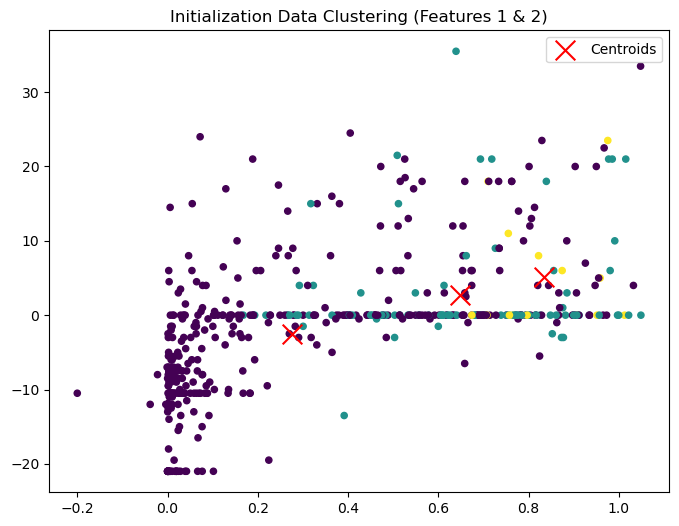

Streaming completed.


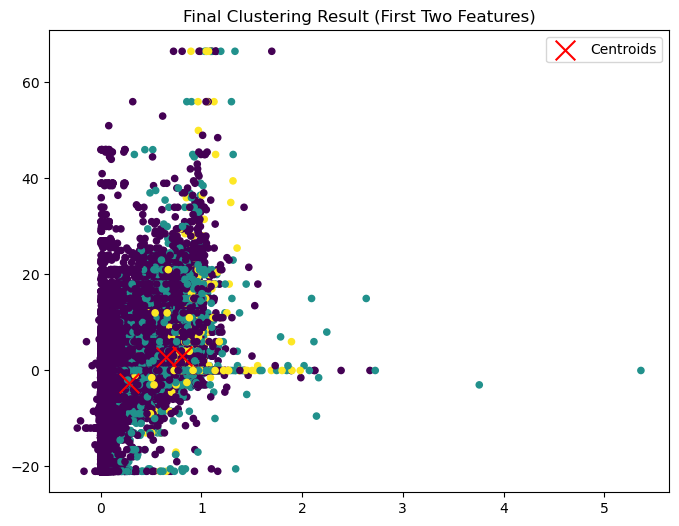

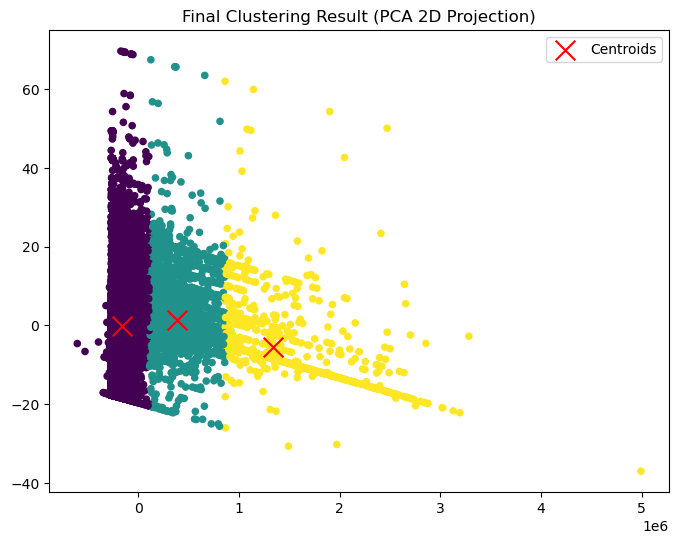

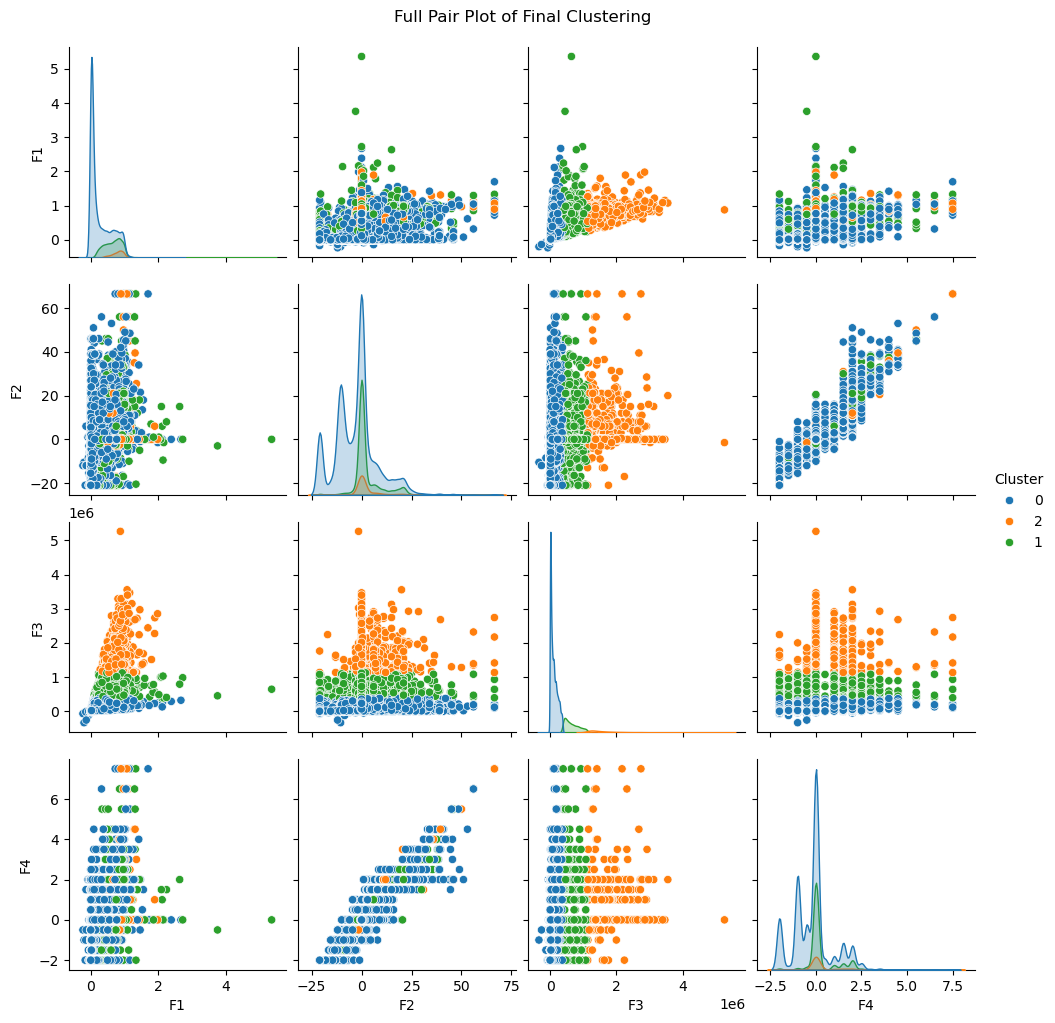

In [255]:
    # Use several batches for initialization.
    init_data = next(stream_gen)
    for _ in range(4):
        try:
            init_data = np.vstack([init_data, next(stream_gen)])
        except StopIteration:
            break

    # Initialize clustering with the initial data.
    state = initialize_kmeans(init_data, random_state=42)
    
    # ----- Visualization 1: Scatter Plot Without PCA -----
    # Use the first two features of the initialization data for a quick view.
    init_labels = np.array([assign_cluster(x, state["centroids"]) for x in init_data])
    plt.figure(figsize=(8, 6))
    plt.scatter(init_data[:, 0], init_data[:, 1], c=init_labels, cmap='viridis', s=20)
    plt.scatter(state["centroids"][:, 0], state["centroids"][:, 1],
                c='red', marker='x', s=200, label='Centroids')
    plt.title("Initialization Data Clustering (Features 1 & 2)")
    plt.legend()
    plt.show()
    
    # Process the remaining stream.
    remaining_points = df.shape[0] - init_data.shape[0]
    state = streaming(stream_gen, state, total_points=remaining_points,
                      drift_check_interval=200, min_update_points=50)
    
    # ----- Visualization 2: Final Clustering Scatter Plot Without PCA -----
    # Use the first two features for a 2D view (without PCA).
    all_data = df.values
    final_labels = np.array([assign_cluster(x, state["centroids"]) for x in all_data])
    
    plt.figure(figsize=(8, 6))
    plt.scatter(all_data[:, 0], all_data[:, 1], c=final_labels, cmap='viridis', s=20)
    plt.scatter(state["centroids"][:, 0], state["centroids"][:, 1],
                c='red', marker='x', s=200, label='Centroids')
    plt.title("Final Clustering Result (First Two Features)")
    plt.legend()
    plt.show()
    
    # ----- Visualization 3: Final Clustering Scatter Plot With PCA -----
    # Reduce the 4D data to 2D using PCA.
    pca = PCA(n_components=2)
    all_data_pca = pca.fit_transform(all_data)
    centroids_pca = pca.transform(state["centroids"])
    
    plt.figure(figsize=(8, 6))
    plt.scatter(all_data_pca[:, 0], all_data_pca[:, 1], c=final_labels, cmap='viridis', s=20)
    plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1],
                c='red', marker='x', s=200, label='Centroids')
    plt.title("Final Clustering Result (PCA 2D Projection)")
    plt.legend()
    plt.show()
    
    # ----- Visualization 4: Full Pair Plot of All Features -----
    # Create a full pair plot (without corner=True) to view all feature pair relationships.
    df_plot = pd.DataFrame(all_data, columns=["F1", "F2", "F3", "F4"])
    df_plot['Cluster'] = final_labels.astype(str)
    sns.pairplot(df_plot, hue='Cluster')  # full pair plot
    plt.suptitle("Full Pair Plot of Final Clustering", y=1.02)
    plt.show()